## Plan of attack

In this notebook, simply just trains the yolov5 to know the type of mask.
My plan is to
1) Change the .xml into .txt files because yolob5 prefers .txt
2) Split the data into train and val (or you can split the test too).
3) Create .yaml that going to tell the model where are our images and labels are located.
5) Train the model..

Note: This is my first notebook for Computer Vision so there won't have much visualization, I tried to use Comet to track the result but there is some problem so I didn't, if you wonder what is it then you can try it yourself, it seems pretty good.


## Import Tool

In [27]:
import matplotlib.pyplot as plt

In [1]:
import urllib
url = "https://raw.githubusercontent.com/Jwizzed/ml-journey/main/TTCV.py"
urllib.request.urlretrieve(url, "TTCV.py")
import TTCV

In [2]:
TTCV.info()

+-----------------------+----------------------------------------------------------+
| Function              | Description                                              |
+=======================+==========================================================+
| report_dir            | Walks through dir_path returning its contents            |
+-----------------------+----------------------------------------------------------+
| unzip                 | Unzips a file                                            |
+-----------------------+----------------------------------------------------------+
| get_lines             | Read the contents of the file and return them as a list  |
+-----------------------+----------------------------------------------------------+
| view_random_image     | Visualize the difference in shape between two DataFrames |
+-----------------------+----------------------------------------------------------+
| get_train_time        | Gets difference between start and end t

## Get data

In [3]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100%|███████████████████████████████████████▉| 397M/398M [00:21<00:00, 18.9MB/s]
100%|████████████████████████████████████████| 398M/398M [00:21<00:00, 19.0MB/s]


In [4]:
TTCV.unzip("face-mask-detection.zip", delete_original=True)

Unzipped Successfully


In [5]:
!ls

TTCV.py                   annotations               images
__pycache__               face_mask_detection.ipynb


In [6]:
TTCV.report_dir("annotations")

*********************************************************
In annotations
Has 0 folder(s): [] 
853 file(s): ['maksssksksss299.xml', 'maksssksksss528.xml', 'maksssksksss272.xml', 'maksssksksss514.xml', 'maksssksksss500.xml', 'maksssksksss266.xml', 'maksssksksss716.xml', 'maksssksksss702.xml', 'maksssksksss845.xml', 'maksssksksss689.xml', 'maksssksksss851.xml', 'maksssksksss138.xml', 'maksssksksss662.xml', 'maksssksksss104.xml', 'maksssksksss110.xml', 'maksssksksss676.xml', 'maksssksksss20.xml', 'maksssksksss448.xml', 'maksssksksss34.xml', 'maksssksksss306.xml', 'maksssksksss460.xml', 'maksssksksss474.xml', 'maksssksksss312.xml', 'maksssksksss475.xml', 'maksssksksss313.xml', 'maksssksksss307.xml', 'maksssksksss461.xml', 'maksssksksss35.xml', 'maksssksksss449.xml', 'maksssksksss21.xml', 'maksssksksss111.xml', 'maksssksksss677.xml', 'maksssksksss663.xml', 'maksssksksss105.xml', 'maksssksksss139.xml', 'maksssksksss850.xml', 'maksssksksss688.xml', 'maksssksksss844.xml', 'maksssksksss703.xml',

In [7]:
TTCV.report_dir("images")

*********************************************************
In images
Has 0 folder(s): [] 
853 file(s): ['maksssksksss702.png', 'maksssksksss716.png', 'maksssksksss299.png', 'maksssksksss266.png', 'maksssksksss500.png', 'maksssksksss514.png', 'maksssksksss272.png', 'maksssksksss528.png', 'maksssksksss312.png', 'maksssksksss474.png', 'maksssksksss460.png', 'maksssksksss306.png', 'maksssksksss448.png', 'maksssksksss34.png', 'maksssksksss20.png', 'maksssksksss851.png', 'maksssksksss689.png', 'maksssksksss845.png', 'maksssksksss676.png', 'maksssksksss110.png', 'maksssksksss104.png', 'maksssksksss662.png', 'maksssksksss138.png', 'maksssksksss139.png', 'maksssksksss105.png', 'maksssksksss663.png', 'maksssksksss677.png', 'maksssksksss111.png', 'maksssksksss844.png', 'maksssksksss688.png', 'maksssksksss850.png', 'maksssksksss21.png', 'maksssksksss35.png', 'maksssksksss449.png', 'maksssksksss461.png', 'maksssksksss307.png', 'maksssksksss313.png', 'maksssksksss475.png', 'maksssksksss529.png', 'mak

## Data preprocess

Change .xml to .txt for YOLOV5, see the docs here: https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#12-create-labels_1

In [8]:
import os
import xml.etree.ElementTree as ET

classes = ['without_mask', 'with_mask', 'mask_weared_incorrect'] # list of classes

def convert_xml_to_txt(xml_dir, txt_dir):
    
    for xml_file in os.listdir(xml_dir):
        
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()
        
        # extract image dimensions
        width = int(root.find('size').find('width').text)  
        height = int(root.find('size').find('height').text)
        
        txt_file = open(os.path.join(txt_dir, os.path.splitext(xml_file)[0] + '.txt'), 'w')
        
        for obj in root.iter('object'):
              
            cls = obj.find('name').text
            if cls not in classes:
                continue
                
            cls_id = classes.index(cls)
            
            xmlbox = obj.find('bndbox')
            x_min = int(xmlbox.find('xmin').text)
            y_min = int(xmlbox.find('ymin').text)
            x_max = int(xmlbox.find('xmax').text)
            y_max = int(xmlbox.find('ymax').text)

            # convert to yolo format
            x_center = (x_min + x_max) / (2*width)
            y_center = (y_min + y_max) / (2*height)
            b_width = (x_max - x_min) / width
            b_height = (y_max - y_min) / height
            
            txt_file.write(f'{cls_id} {x_center} {y_center} {b_width} {b_height}\n')

        txt_file.close()

In [9]:
os.mkdir("labels")

In [10]:
# Usage
xml_dir = 'annotations/' 
txt_dir = 'labels/'
convert_xml_to_txt(xml_dir, txt_dir)

In [11]:
TTCV.report_dir("labels")

*********************************************************
In labels
Has 0 folder(s): [] 
853 file(s): ['maksssksksss628.txt', 'maksssksksss614.txt', 'maksssksksss172.txt', 'maksssksksss166.txt', 'maksssksksss600.txt', 'maksssksksss6.txt', 'maksssksksss833.txt', 'maksssksksss199.txt', 'maksssksksss827.txt', 'maksssksksss56.txt', 'maksssksksss42.txt', 'maksssksksss358.txt', 'maksssksksss370.txt', 'maksssksksss416.txt', 'maksssksksss402.txt', 'maksssksksss364.txt', 'maksssksksss95.txt', 'maksssksksss81.txt', 'maksssksksss238.txt', 'maksssksksss204.txt', 'maksssksksss562.txt', 'maksssksksss576.txt', 'maksssksksss210.txt', 'maksssksksss589.txt', 'maksssksksss748.txt', 'maksssksksss760.txt', 'maksssksksss774.txt', 'maksssksksss775.txt', 'maksssksksss761.txt', 'maksssksksss749.txt', 'maksssksksss588.txt', 'maksssksksss577.txt', 'maksssksksss211.txt', 'maksssksksss205.txt', 'maksssksksss563.txt', 'maksssksksss239.txt', 'maksssksksss80.txt', 'maksssksksss94.txt', 'maksssksksss403.txt', 'maksssk

In [12]:
import shutil
folder = 'annotations'
shutil.rmtree(folder)

In [13]:
os.mkdir("train")
os.mkdir("val")
os.mkdir("test")

os.mkdir("train/images")
os.mkdir("train/labels")

os.mkdir("val/images")
os.mkdir("val/labels")

os.mkdir("test/images")
os.mkdir("test/labels")

In [14]:
from sklearn.model_selection import train_test_split
import os

images = sorted(os.listdir('images'))
labels = sorted(os.listdir('labels'))



# Align images and labels
zipped = list(zip(images, labels))

# Split with stratify to balance classes
train_data, test_data = train_test_split(zipped, test_size=0.2) 

# Unzip
train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)


# Copy to folders
for img, lbl in train_data:
   shutil.copy(f'images/{img}', 'train/images/')
   shutil.copy(f'labels/{lbl}', 'train/labels/') 

for img, lbl in test_data:
   shutil.copy(f'images/{img}', 'test/images/')
   shutil.copy(f'labels/{lbl}', 'test/labels/') 


## Get a model

In [15]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 15921 (delta 17), reused 28 (delta 13), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.66 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (10916/10916), done.


In [16]:
%cd yolov5
!ls

/Users/krittinsetdhavanich/Downloads/ml-journey/Datasets/CV/face_mask_detection/yolov5
CITATION.cff     benchmarks.py    hubconf.py       train.py
CONTRIBUTING.md  classify         models           tutorial.ipynb
LICENSE          data             requirements.txt utils
README.md        detect.py        segment          val.py
README.zh-CN.md  export.py        setup.cfg


In [17]:
%cd ..

/Users/krittinsetdhavanich/Downloads/ml-journey/Datasets/CV/face_mask_detection


In [18]:
!ls

TTCV.py                   images                    train
__pycache__               labels                    val
face_mask_detection.ipynb test                      yolov5


In [19]:
text = """train: ../train/images
val: ../test/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("anno.yaml", 'w') as file:
    file.write(text)

In [23]:
!python3 yolov5/train.py --img 640 --epochs 3 --data anno.yaml --weights yolov5/yolov5s.pt

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo-1.8.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
train: weights=yolov5/yolov5s.pt, cfg=, data=anno.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.11.0 torch-2.0.1 CPU

hyperparameter

Model summary: 214 layers, 7027720 parameters, 7027720 gradients, 16.0 GFLOPs

Transferred 343/349 items from yolov5/yolov5s.pt
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 60 weight(decay=0.0005), 60 bias
train: Scanning /Users/krittinsetdhavanich/Downloads/ml-journey/Datasets/CV/face
val: Scanning /Users/krittinsetdhavanich/Downloads/ml-journey/Datasets/CV/face_m

AutoAnchor: 5.60 anchors/target, 0.999 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to yolov5/runs/train/exp2/labels.jpg... 
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov5/runs/train/exp2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        0/2         0G      0.121    0.04493    0.04351         98        640:  libpng warning: iCCP: Not recognizing known sRGB profile that has bee

COMET INFO: Still saving offline stats to messages file before program termination (may take up to 120 seconds)
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload /Users/krittinsetdhavanich/Downloads/ml-journey/Datasets/CV/face_mask_detection/.cometml-runs/d2d3025dc80747c9a1f86bb43371791f.zip


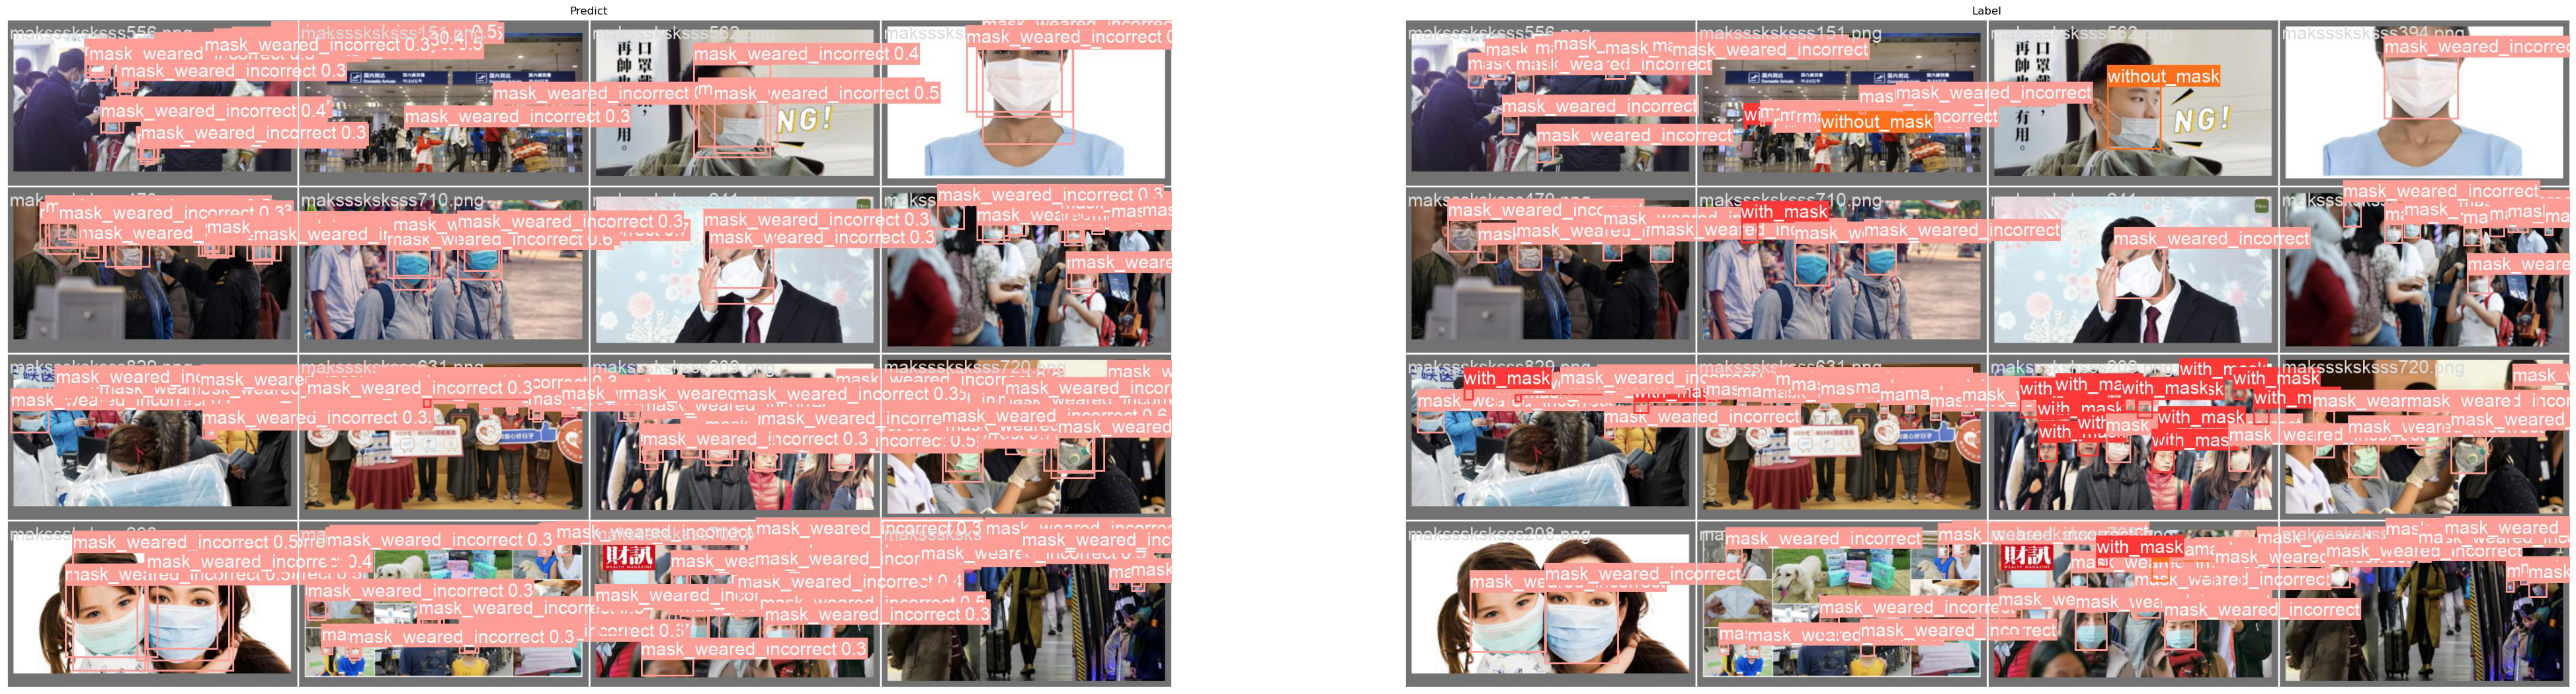

In [34]:
plt.figure(figsize=(50, 25))
plt.subplot(1,2,1)
img1 = plt.imread('yolov5/runs/train/exp2/val_batch0_pred.jpg')
plt.title("Predict")
plt.imshow(img1)
plt.axis('off')

plt.subplot(1,2,2)
img2 = plt.imread('yolov5/runs/train/exp2/val_batch0_labels.jpg')
plt.title("Label")
plt.imshow(img2)
plt.axis('off')

plt.show()